In [120]:
#@authors: Isabel Burgos, Francesca Drummer, Lennart Geertjes, Madelief Rennspies, Ellen Schrader
# for inline plots in jupyter
%matplotlib inline
# import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(4.5,3)})
# import distributions
from scipy.stats import *
import numpy as np

In [121]:
#This function returns the feature of the tile flipped and the object below it. 
#Theta = vector of category probabilities of the features
#Psi = vector of category probabilities of the objects given the features (deterministic)
#The number of objects n and features k is included implicitly in the size of the corresponding arrays
def environment(theta_1, theta_2,psi):
    #Draw feature from a categorical distribution
    feature = np.array(multinomial.rvs(p = theta_1, n = 1))
    location = np.array(multinomial.rvs(p = theta_2, n = 1))
    
    #Get index of location and feature (starting at 0)
    idx_feature = list(feature).index(1)
    idx_location = list(location).index(1)
    
    #Draw the object from a categorical distribution given the feature
    obj     = multinomial.rvs(p = psi[idx_feature, idx_location].flatten(), n = 1)
    
    #Get index of object
    idx_object  = list(obj).index(1)
    
    return idx_feature, idx_object, idx_location

In [122]:
#Model of the agent. The function returns the predicted probability distribution over the objects given the features
#and the index of the predicted object
#Note: we might not need the predicted object and the index of the object itself but it is still included as it might
#be useful for some of us
def agent(psi, alpha, idx_feature, idx_location):
    psi[idx_feature, idx_location, :] = dirichlet.rvs(alpha[idx_feature, idx_location,:])
    obj = multinomial.rvs(p=psi[idx_feature, idx_location, :], n=1)
    idx_object  = list(obj).index(1)
    return psi, idx_object

In [123]:
#The agent learns the probability distribution of the objects given a specific feature
#n_iter = the number of iterations in this observations the agent sees
#n_objects = the number of objects
#n_features = the number of features and thus also of tiles

def trial(n_iter, n_objects, n_features, n_locations, psi_env):
    ####Initial values###
    alpha = np.full((n_features, n_locations, n_objects), 1) ## added n_location as 2nd parameter such that matrix looks the same as for psi_env
    #pre_errors = [[[]]*(n_locations)]*(n_features)
    pre_errors = [[[] for _ in range(n_locations)] for _ in range(n_features)]  # made list comprehensions such that the list object is new each time
    psi_agent = np.full((n_features, n_locations, n_objects), 1/n_objects) ## added n_location as 2nd parameter such that matrix looks the same as for psi_env
    #If you want specific features to occur more often change e.g., to theta = [0.8,0.1,0.1]
    theta_1 = np.repeat(1/n_features,n_features)
    theta_2 = np.repeat(1/n_locations,n_locations)
    
    ###Updating the agent's generative model###
    for i in range(0,n_iter):
        
        #Get feature and observation from environment
        idx_feature, idx_object, idx_location = environment(theta_1, theta_2, psi_env)
        
        #Prediction of the agent
        psi_agent, _ =  agent(psi_agent, alpha, idx_feature, idx_location)
        
        #Calculate prediction error using relative entropy (Kullback-Leibler divergence)
        pre_err=entropy(psi_agent[idx_feature, idx_location],psi_env[idx_feature, idx_location], base=None)
        pre_errors[idx_feature][idx_location].append(pre_err)
        
        #Updating hyperparameters
        alpha[idx_feature, idx_location, idx_object]+=1    
    return alpha, pre_errors

[[[ 73  12  25  15]
  [  1   1   1 117]
  [ 64  12  28   6]]

 [[  1   1 103   1]
  [  1   1   1  95]
  [  1   1 118   1]]

 [[  1 109   1   1]
  [  1   1   1 126]
  [  1 112   1   1]]]
[2.3600820909937026, 1.2681317578321853, 3.815255384136362, 2.0930801047650185, 2.6725367362468164, 2.184779379689134, 0.8709127612206046, 3.221171050516704, 2.8339739664195824, 1.0379151827112851, 0.960431092681925, 2.2160539804810653, 1.2010648313108134, 1.043488720422223, 1.206390358250944, 1.647113162061657, 2.3985291711841517, 0.7609613724630601, 2.869568649958029, 1.8270027538829008, 2.4055302972361536, 1.069550958098363, 2.025440354006925, 1.9608486206142544, 2.8724898150016553, 1.3150941166669765, 3.0678852168243704, 0.7789803455656551, 2.872158458450849, 1.9105160093215192, 1.6283287105296513, 1.7913282042513172, 1.68754637024975, 1.0953560337239368, 1.085696241363881, 0.9777776420671758, 1.21182504262863, 0.6210122011108217, 0.9913132009380075, 0.5160780666627028, 0.48994573723368257, 0.519123

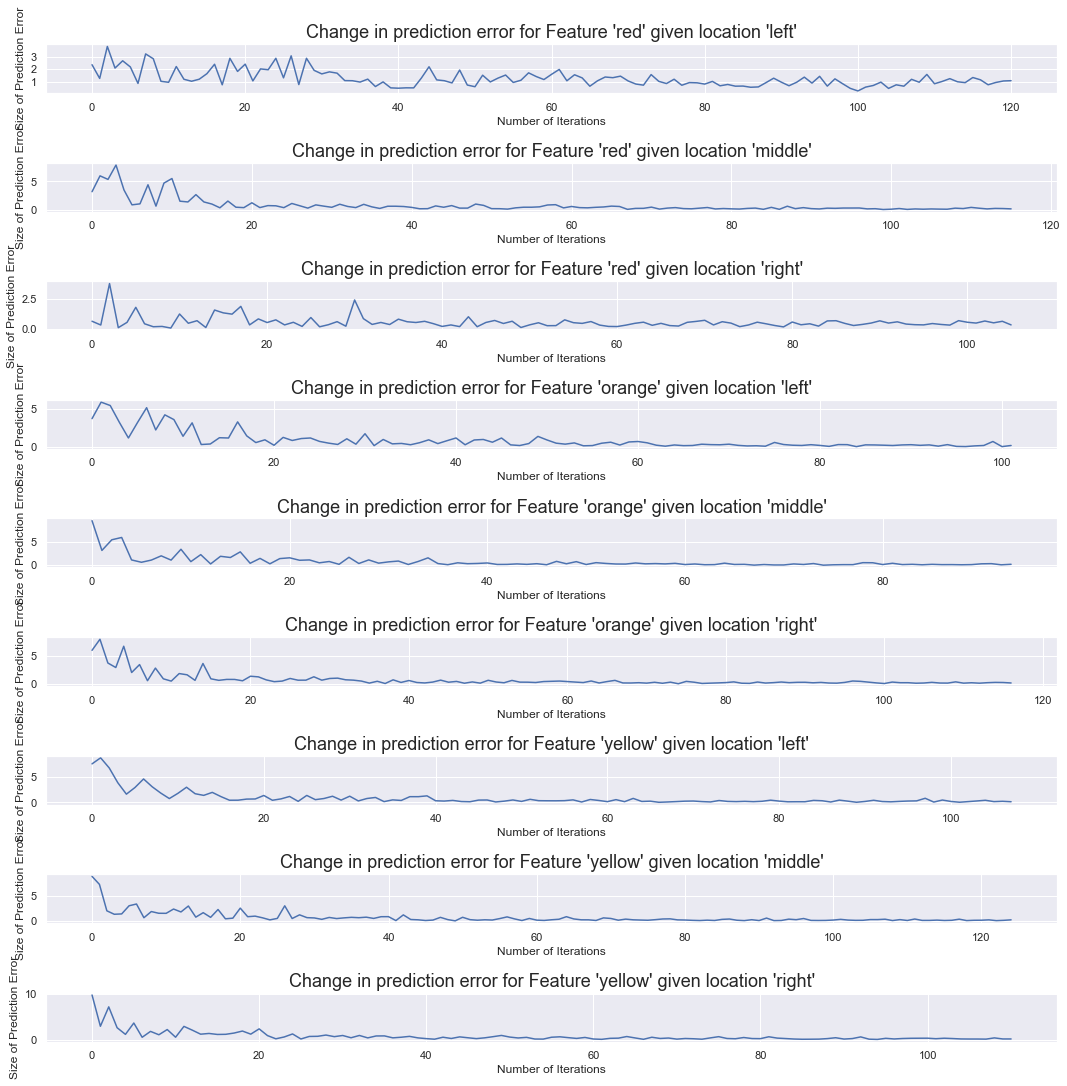

In [129]:
###Running the simulation###

#The environment is supposed to be deterministic but 
#due to the nature of Kullback Leibler divergence the probabilities cannot be zero.
#                             Left                                Middle                               Right
psi_env = np.array([[[0.99997,0.00001,0.00001,0.00001],[0.00001,0.00001,0.00001,0.99997],[0.99997,0.00001,0.00001,0.00001]],
                    [[0.00001,0.00001,0.99997,0.00001],[0.00001,0.00001,0.00001,0.99997],[0.00001,0.00001,0.99997,0.00001]],
                    [[0.00001,0.99997,0.00001,0.00001],[0.00001,0.00001,0.00001,0.99997],[0.00001,0.99997,0.00001,0.00001]]])
f_names = ["red", "orange", "yellow"]
o_names = ["circle", "square", "triangle","star"]
l_names = ["left", "center", "right"]
alpha, pre_errors = trial(1000, len(o_names), len(f_names), len(l_names), psi_env) ##  added len(list) instead of hardcoding the length.

print(alpha)

k=0
fig, ax = plt.subplots(len(f_names)*len(l_names), 1, figsize=(15,15)) ## added len(list) instead of hardcoding the length.
for i in range(len(f_names)):
    for j in range(len(l_names)):
        ax[k].plot(pre_errors[i][j])
        ax[k].set_title("Change in prediction error for Feature '{}' given location '{}'".format(f_names[i],l_names[j]), fontsize=18)    
        ax[k].set_xlabel("Number of Iterations")
        ax[k].set_ylabel("Size of Prediction Error")
        k+=1
fig.tight_layout()    